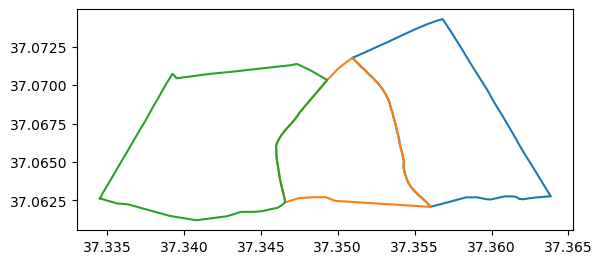

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from random import choices
from trial_1 import Building
from trial_1 import Area
from shapely.geometry import Polygon
from shapely.geometry import box

# defines a function which imports multiple areas
def import_areas(addresses):
    areas = []
    areas_gdf = []
    for address in addresses:
        # loads the area as a geodataframe
        area_gdf = ox.geocode_to_gdf(address)
        areas_gdf.append(area_gdf)

        # extracts the area id, name and addresstype
        area_id = area_gdf.loc[0, 'osm_id']
        geometry = area_gdf.loc[0, 'geometry']
        name = area_gdf.loc[0, 'name']
        address = address
        addresstype = area_gdf.loc[0, 'addresstype']

        minx = area_gdf.loc[0, 'bbox_west']
        miny = area_gdf.loc[0, 'bbox_south']
        maxx = area_gdf.loc[0, 'bbox_east']
        maxy = area_gdf.loc[0, 'bbox_north']
        bbox = box(minx, miny, maxx, maxy)

        # creates an area object and appends it to the list
        area = Area(area_id, geometry, bbox, name, address, addresstype)
        areas.append(area)
    return areas, areas_gdf

addresses = ['Sarıgüllük Mahallesi', 'Gazi Mah., Gaziantep', 'Pancarlı Mahallesi']
areas, areas_gdf = import_areas(addresses)

# print(areas[0].geometry.type)
# print(areas_gdf)
# print(areas[0].name, areas[0].area_id, areas[0].addresstype)

fig, ax = plt.subplots()
ax.set_aspect('equal')

for a in areas:
    # Extract the exterior boundary of the area geometry
    polygon = a.geometry.exterior

    # Plot the exterior boundary using Matplotlib
    x, y = polygon.xy
    ax.plot(x, y)  # You can set a specific color

plt.show()

In [3]:
# defines a function which imports all buildings in an area
def import_buildings(area):
    # importing osm location
    geometry = area.geometry
    buildings = ox.features.features_from_polygon(geometry, tags={'building': True})

    # creating object for each building
    bld_lst = []
    for i in buildings.index:
        id = i[1]
        geo = buildings.loc[i, 'geometry']
        center_point = geo.centroid
        bld_function = buildings.loc[i, 'building']

        bld = Building(id, geo, center_point, bld_function)
        bld_lst.append(bld)
        area.add_building(bld)
    return bld_lst, area

for a in areas:
    buildings, area = import_buildings(a)
    print(len(a.buildings))

407
295
428


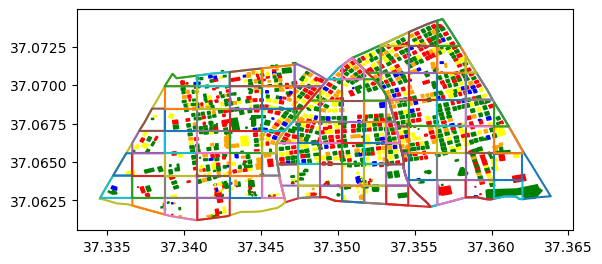

In [4]:
import numpy as np
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mpl_polygon
from trial_1 import Sub_Area
from trial_1 import Area

# defines a function which generates sub_areas by dividing the boundary of all combined buildings in cells, x_steps = n of cells in x dir, y_steps = n of cells in y dir, and associating buildings with sub_areas
def generate_sub_areas(area, buildings, x_steps, y_steps):
    # set bounds of graph to the bounds of center points
    xmin, ymin, xmax, ymax = area.bbox.bounds
    x_range = xmax - xmin
    y_range = ymax - ymin

    # set stepsize
    width = x_range / x_steps
    height = y_range / y_steps

    # create cols and rows based on bounds and stepsize
    cols = list(np.arange(xmin, xmax + width, width))
    rows = list(np.arange(ymin, ymax + height, height))

    # sort the list of buildings objects based on x coordinates, then y coordinates
    sorted_blds = sorted(buildings, key=lambda x: (x.center_point.x, x.center_point.y))

    # create cells and plot to graph, add buildings to subarea classes
    sub_areas = []
    i = 0
    j = 0
    for x in cols[:-1]:
        # while the buildings have x values in the range of this column, add them to a list
        filt_blds = []
        while (i < len(sorted_blds)) and (sorted_blds[i].center_point.x >= x) and (sorted_blds[i].center_point.x < (x+width)): 
            filt_blds.append(sorted_blds[i])
            filt_blds = sorted(filt_blds, key=lambda x: (x.center_point.y))
            i += 1
            
        for y in rows[:-1]:
            # create a cell, sub_area object, and associate the cell with the object
            polygon = Polygon([(x,y), (x+width, y), (x+width, y+height), (x, y+height)])
            sub_area = Sub_Area(j, polygon)
            
            # while the buildings in that column have y values in the range of this row, add them to the cell object 
            while (len(filt_blds) > 0) and (filt_blds[0].center_point.y >= y) and (filt_blds[0].center_point.y < (y+height)):
                sub_area.add_building(filt_blds.pop(0))

            # only add the sub_area if it has buildings in it
            if sub_area.buildings != []:
                sub_areas.append(sub_area)
            
                # add the sub_areas to the area
                area.add_sub_area(sub_area)

                # crop the geometry of the sub_area with the are geometry
                sub_area.crop_geometry()

                j += 1           
    return sub_areas

# create the sub_areas for each area
for a in areas:
    generate_sub_areas(a, a.buildings, 7, 7)

# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_geometry(areas):
    # create empty graph and plot sub_area geometry to graph
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    for a in areas:
        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y)  # You can set a specific color

        # plot the sub_area geometry        
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy)
        
        # plot the building geometry
        # save each building geometry attribute in a list
        geos = [o.geometry for o in a.buildings]

        # choices of different colours with corresponding weights
        population = ['green', 'blue', 'yellow', 'orange', 'red']
        weights = [0.45, 0.05, 0.15, 0.12, 0.23]

        # for every geometry choose a colour, fill the geometry and plot to graph
        for g in geos:
            c = choices(population, weights)[0]
            x, y = g.exterior.xy
            ax.fill(x, y, color = c)

    # Display the plot
    plt.show()

# show the geometry for each area, sub_area and building
show_geometry(areas)

In [5]:
def allocate_teams_to_areas(areas, sector_n_heavy_teams, sector_n_med_teams, sector_n_light_teams):
    # define the number of people per team
    heavy_n_people = 24
    medium_n_people = 12
    light_n_people = 6

    # calculate the total number of people required
    total_people = heavy_n_people * sector_n_heavy_teams + medium_n_people * sector_n_med_teams + light_n_people * sector_n_light_teams
    total_priority = 0
    for a in areas:
        total_priority += a.priority_weight
    # calculate the number of people required per priority weight
    people_per_priority = total_people / total_priority

    # calculate the number of people required per area
    for a in areas:
        a.people_requirement = a.priority_weight * people_per_priority

    # sort the areas by people requirement
    sorted_areas = sorted(areas, key=lambda x: (x.people_requirement), reverse=True)

    # reset allocation of teams
    for a in areas:
        a.heavy_teams = 0
        a.med_teams = 0
        a.light_teams = 0

    # allocate teams to areas
    while sector_n_heavy_teams > 0 or sector_n_med_teams > 0 or sector_n_light_teams > 0:
        if sector_n_heavy_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].heavy_teams += 1
            sector_n_heavy_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= heavy_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
        elif sector_n_med_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].med_teams += 1
            sector_n_med_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= medium_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
        elif sector_n_light_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].light_teams += 1
            sector_n_light_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= light_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
    
# allocate teams to areas based of input of number of teams (heavy, med, light) per sector
allocate_teams_to_areas(areas, 2, 1, 1)
print([[o.heavy_teams, o.med_teams, o.light_teams] for o in areas])


[[1, 0, 0], [1, 0, 0], [0, 1, 1]]


In [6]:
from trial_1 import Team
from trial_1 import Sub_Team
from trial_1 import Team_Member
import random
import pandas as pd

# defines a function which creates team, sub-team and team_member objects based on a number of heavy, medium and light teams in an area
def set_teams(heavy, med, light, police, fire_fighters, task_force):
    # set number of heavy, medium, light, police, fire_fighters and task_force teams
    n_heavy = heavy
    n_med = med
    n_light = light
    n_police = police
    n_fire_fighters = fire_fighters
    n_task_force = task_force

    # initialise list of teams and team ids
    teams = []
    team_id = 0
    sub_team_id = 0
    team_member_id = 0

    # create heavy teams, subteams and teammembers
    for i in range(n_heavy):
        team = Team(team_id, 'heavy')
        for j in range(4):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id)
                sub_team.add_team_member(team_member)
                team_member_id += 1
            sub_team.calculate_action_counts()
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1
   
    # create medium teams, subteams and teammembers
    for i in range(n_med):
        team = Team(team_id, 'medium')
        for j in range(2):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id)
                sub_team.add_team_member(team_member)
                team_member_id += 1
            sub_team.calculate_action_counts()
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1
        
    # create light teams, subteams and teammembers
    for i in range(n_light):
        team = Team(team_id, 'light')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id)
                sub_team.add_team_member(team_member)
                team_member_id += 1
            sub_team.calculate_action_counts()
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1
    
    # create police_team, subteam and teammembers
    for i in range(n_police):
        team = Team(team_id, 'police')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id)
            for k in range(4):
                team_member = Team_Member(team_member_id)
                sub_team.add_team_member(team_member)
                team_member_id += 1
            sub_team.calculate_action_counts()
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1

    # create fire_fighters team, subteam and teammembers
    for i in range(n_fire_fighters):
        team = Team(team_id, 'fire_fighters')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id)
            for k in range(4):
                team_member = Team_Member(team_member_id)
                sub_team.add_team_member(team_member)
                team_member_id += 1
            sub_team.calculate_action_counts()
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1

    # create task force team, subteams and teammembers
    for i in range(n_task_force):
        team = Team(team_id, 'task_force')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id)
                sub_team.add_team_member(team_member)
                team_member_id += 1

            # Calculate action counts for the sub-team
            action_counts = sub_team.calculate_action_counts()

            # Assign the action counts to the sub-team if needed
            sub_team.action_counts = action_counts
            # Define the weights for each skill
            weights = {
                'struc': 1,  # Weight for Structural Rescue skill
                'trench': 0.1,  # Weight for Trench Rescue skill
                'rope': 0.7,  # Weight for Technical Rope Rescue skill
                'conf_space': 0.7,  # Weight for Confined Space Rescue skill
                'hazmat': 0.2,  # Weight for HazMat Rescue skill
                'rigging': 0.1  # Weight for Heavy Rigging skill
            }
            sub_team.competence = sub_team.calculate_total_competence(weights)  # Calculate the total_competence for the sub-team
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1

    # Return the 'teams' list after creating all teams
    return teams

In [23]:
area = areas[0]
sub_areas = area.sub_areas
print(sub_areas)

# create the teams
# teams = set_teams(area.heavy_teams, area.med_teams, area.light_teams, 1, 1, 1)
teams = set_teams(0, 0, 0, 0, 0, 5)

# defines a function which puts all subteams in multiple teams 
def get_sub_teams(teams):
    # access and create sub_teams list
    sub_teams = []
    for tm in teams:
        for stm in tm.sub_teams:
            sub_teams.append(stm)
    return sub_teams

sub_teams = get_sub_teams(teams)
sub_team_members = [o.team_members for o in sub_teams]
print(sub_teams)
print(sub_team_members)

# Create a list to store team IDs and names
team_info = []
# Iterate through the teams and extract their IDs and names
for team in teams:
    print(team.sub_teams)
    team_info.append((team.team_id, team.team_type, team.sub_teams))
# Print the list of team IDs and names
print("Team IDs and Names:")
for team_id, team_name, sts in team_info:
    print(f"Team ID: {team_id}, Team Name: {team_name}, Sub-Teams: {sts}")

[<trial_1.Sub_Area object at 0x0000021B52DAF070>, <trial_1.Sub_Area object at 0x0000021B5AD357F0>, <trial_1.Sub_Area object at 0x0000021B5AD35610>, <trial_1.Sub_Area object at 0x0000021B5AD35FD0>, <trial_1.Sub_Area object at 0x0000021B5AD35C40>, <trial_1.Sub_Area object at 0x0000021B5AFF9430>, <trial_1.Sub_Area object at 0x0000021B5AFF9310>, <trial_1.Sub_Area object at 0x0000021B5AFF9550>, <trial_1.Sub_Area object at 0x0000021B5AFF9340>, <trial_1.Sub_Area object at 0x0000021B5AFF9040>, <trial_1.Sub_Area object at 0x0000021B5AED7C40>, <trial_1.Sub_Area object at 0x0000021B5AED7CA0>, <trial_1.Sub_Area object at 0x0000021B5AED7CD0>, <trial_1.Sub_Area object at 0x0000021B5AED7D00>, <trial_1.Sub_Area object at 0x0000021B5AED7D60>, <trial_1.Sub_Area object at 0x0000021B5AED7DC0>, <trial_1.Sub_Area object at 0x0000021B5AED7DF0>, <trial_1.Sub_Area object at 0x0000021B5AED7E20>, <trial_1.Sub_Area object at 0x0000021B5AED7E50>, <trial_1.Sub_Area object at 0x0000021B5AED7E80>, <trial_1.Sub_Area o

In [8]:
# Example: print the weight of a sub-team[] in a team[]
print(f"The phase1 overall competence weight is:", round(teams[0].sub_teams[0].total_competence, 2))
print("-" * 30)
# Example: Print the dictionary for the first sub-team in the first heavy team
sub_team = teams[0].sub_teams[0]
action_counts = sub_team.calculate_action_counts()

if action_counts:
    for action, count in action_counts.items():
        print(f"{action}: {count}")
else:
    print("No actions available for this sub-team.")

The phase1 overall competence weight is: 22.8
------------------------------
Advanced Scene Assessment: 5
Advanced Medical Care and Triage: 5
Advanced Shoring Techniques: 5
Complex Casualty Extrication: 5
Size-up and Scene Safety: 6
Casualty Assessment and Basic Medical Care: 6
Shoring and Stabilization (Basic): 6
Safe Access and Egress: 6
Incident Command and Coordination: 2
Multiple Casualties and Complex Trench Configurations: 2
Technical Trench Rescue:: 2
Integrate with Other Disciplines: 3
Scene Assessment and Safety: 3
Hazard Recognition: 3
Casualty Assessment and Basic Care: 3
Trench Shoring and Stabilization (Basic): 3
Advanced Hazard Recognition: 3
Advanced Shoring and Trench Box Systems: 3
Casualty Packaging and Extrication: 3
Equipment Operation: 3
Advanced Knot Tying: 2
Complex Rope Systems: 2
Difficult Access: 2
Confined Space Rope Rescue: 2
Knot Tying: 4
Anchor Systems: 4
Ascending and Descending: 4
Rigging and Mechanical Advantage: 4
Complex and Hazardous Incidents: 2
Le

In [24]:
# defines a function which allocates sub_team(s) to sub_area(s) based on priority weight and competence, works with sub_teams list or single object
def allocate_sub_team(sub_areas, sub_teams):
    # sorts the sub_areas so that the sub_areas with the highest priority weight are first in the list
    sub_areas = sorted(sub_areas, key=lambda x: (x.priority_weight), reverse=True)

    # links the objects of sub_teams to sub_areas and removes the sub_areas that are allocated from the sub_areas list
    if hasattr(sub_teams, '__iter__'):

        # sorts the sub_teams so that the sub_teams with the highest competence are first in the list
        sub_teams = sorted(sub_teams, key=lambda x: (x.total_competence), reverse=True)
        
        # assigns sub_areas to sub_teams
        for i, o in enumerate(sub_teams):
            o.assign_sub_area(sub_areas.pop(0))
            o.rem_time -= o.sub_area.clear_time
            o.sub_area.cleared = True
    else:
        sub_teams.assign_sub_area(sub_areas.pop(0))
    return sub_areas

print([o.priority_weight for o in sub_areas])
print([o.total_competence for o in sub_teams])
print(len(sub_areas))
print(len(sub_teams))

# allocate all teams during start
rem_sub_areas = allocate_sub_team(sub_areas, sub_teams)

# sort the sub_teams by remaining time
sorted_sub_teams = sorted(sub_teams, key=lambda x: (x.rem_time), reverse=True)
print(f'rem_time: {[o.rem_time for o in sorted_sub_teams]}')

# allocate teams while there are sub_areas left and while there are teams with remaining time
while (len(rem_sub_areas) > 0) and any(o.rem_time > 0 for o in sorted_sub_teams):
    rem_sub_areas = allocate_sub_team(rem_sub_areas, sorted_sub_teams[0])
    sorted_sub_teams = sorted(sorted_sub_teams, key=lambda x: (x.rem_time), reverse=True)
    print(f'rem_time: {[o.rem_time for o in sorted_sub_teams]}')

print(f'rem_time: {[o.rem_time for o in sorted_sub_teams]}')
print([o.priority_weight for o in sub_areas])
print([o.total_competence for o in sub_teams])
print(len(rem_sub_areas))
print(len(sub_areas))

# # allocate a team after the team cleared a sub_area
# rem_sub_areas = allocate_sub_team(rem_sub_areas, sub_teams[0])
# print(len(rem_sub_areas))
# print(len(sub_areas))

# WHY DOES IT KEEP REMOVING ITEMS FROM THE sub_areas LIST, VARIABLES IN A FUNCTION SHOULD BE LOCAL???

[1.2518518518518518, 1.0126984126984127, 1.6333333333333333, 1.0222222222222221, 0.6192592592592593, 1.0357487922705313, 1.2974358974358975, 1.3511111111111112, 0.8133333333333334, 1.4977777777777779, 1.211111111111111, 1.2444444444444445, 1.107936507936508, 1.16, 1.1074074074074074, 0.8222222222222222, 0.9277777777777778, 1.0252525252525253, 1.1978835978835978, 1.1507936507936507, 1.2733333333333334, 1.2577777777777779, 1.3111111111111111, 0.8275132275132275, 1.29281045751634, 1.27, 1.2507936507936508, 0.28888888888888886, 0.37777777777777777, 1.6666666666666667, 1.7555555555555555, 1.6]
[20.900000000000002, 24.2, 23.799999999999997, 22.5, 25.199999999999996]
32
5
rem_time: [1350, 1305, 1260, 1260, 990]
rem_time: [1350, 1305, 1260, 1260, 990]
rem_time: [1350, 1305, 1260, 1260, 990]
rem_time: [1350, 1305, 1260, 1260, 990]
rem_time: [1350, 1305, 1260, 1260, 990]
rem_time: [1350, 1305, 1260, 1260, 990]
rem_time: [1350, 1305, 1260, 1260, 990]
rem_time: [1350, 1305, 1260, 1260, 990]
rem_ti

In [9]:
import math
import itertools

def allocate_sub_team_p2(sub_areas, sub_teams):
    # allocation of sub_teams in an area to sub_areas phase 2
    total_action_count_list = []

    for s in sub_teams:
        serveable_sub_areas = {}
        sub_areas_priorities = []

        # filter the sub_areas list to only include sub_areas that have not been cleared and that have required actions that the sub_team can perform
        for sa in sub_areas:
            # check if the sub_team has the available actions required to clear the sub_area
            if (all(required_action in s.action_counts for required_action in sa.required_actions)) and (sa.cleared == False):
                # create priority weights for each sub_area based on the criteria and how well the required actions match the available actions
                # adding up all the counts of people who can perform each required action
                total_action_count = 0
                for required_action in sa.required_actions:
                    total_action_count += s.action_counts[required_action]
                
                # creating a factor based on the total_action_count, to multiply the estimated time with
                sub_team_efficiency = 1.5 * (1 - math.exp(- (0.0193 * total_action_count))) + 0.5
                factored_priority_weight = sa.priority_weight * sub_team_efficiency
                serveable_sub_areas[sa] = factored_priority_weight

                total_action_count_list.append(total_action_count)

                # print('sub_team_actions:', s.action_counts.keys())
                # print('sub_area_req_actions:', sa.required_actions)
                # print('total_action_count:', total_action_count)
                # print('clear_time:', sa.clear_time)
                # print('priority_weight:', sa.priority_weight)
                # print('sum_building_weights:', sa.clear_time * sa.priority_weight)
                # print('sub_team_efficiency:', sub_team_efficiency)
                # print('factored_clear_time:', sa.priority_weight / sub_team_efficiency)
                # print('factored_priority_weight:', factored_priority_weight)
        
        serveable_sub_areas = sorted(serveable_sub_areas.items(), key=lambda x: (x[1]), reverse=True)
        s.serveable_sub_areas = serveable_sub_areas

    # slice the serveable_sub_areas dictionary to the amount of subteams in the area
    sliced_sub_areas = [dict(itertools.islice(o.serveable_sub_areas, len(sub_teams))) for o in sub_teams]

    # Create an empty list to store all combinations
    all_combinations = []

    # Calculate the Cartesian product of serveable sub-areas for each sub-team
    for combination in itertools.product(*sliced_sub_areas):
        # append combination to all_combinations, 'combination' is a list sub_area objects
        all_combinations.append(combination)
        
    # Filter any combinations that contain duplicate sub-areas
    filtered_combinations = list(filter(lambda x: len(x) == len(set(sub_area for sub_area in x)), all_combinations))
    print('amount of combinations:', len(all_combinations),
        '\namount of combinations after filtering:', len(filtered_combinations), 
        '\namount of filtered combinations:', ((len(all_combinations)) - (len(filtered_combinations))))

    # Associating the sub_area objects with their priority weights and finding the highest priority combination
    best_combination_score = 0
    best_combination = None

    for i, combination in enumerate(filtered_combinations):
        combination_score = 0
        print(f"Combination {i}:")
        for j, sub_area in enumerate(combination):
            priority = sliced_sub_areas[j][sub_area] # Access the sub-area object and priority
            print(f"Sub-area: {sub_area}, Priority: {priority}")
            combination_score += priority
        print(f"Combination score: {combination_score}")
        if combination_score >= best_combination_score:
            best_combination_score = combination_score
            best_combination = combination

    # Getting priority weights for the best combination
    print(f"Best combination score: {best_combination_score}")
    for i, sub_area in enumerate(best_combination):
            priority = sliced_sub_areas[i][sub_area] # Access the sub-area object and priority
            print(f"Sub-area: {sub_area}, Priority: {priority}")
            sub_teams[i].assign_sub_area(sub_area)
            sub_teams[i].sub_area_priority = priority

    # total_action_count_median = np.median(total_action_count_list)
    # total_action_count_average = np.average(total_action_count_list)
    # print('total_action_count_median:', total_action_count_median)
    # print('total_action_count_average:', total_action_count_average)
    
allocate_sub_team_p2(sub_areas, sub_teams)
print([o.sub_area for o in sub_teams])
print([o.sub_area_priority for o in sub_teams])

amount of combinations: 625 
amount of combinations after filtering: 449 
amount of filtered combinations: 176
Combination 0:
Sub-area: <trial_1.Sub_Area object at 0x000002274AA2D970>, Priority: 0.6597565241718538
Sub-area: <trial_1.Sub_Area object at 0x000002274AA27A30>, Priority: 0.6655197585715406
Sub-area: <trial_1.Sub_Area object at 0x000002274AA27B20>, Priority: 0.5603342215601611
Sub-area: <trial_1.Sub_Area object at 0x000002274AA2D940>, Priority: 0.571749320569164
Sub-area: <trial_1.Sub_Area object at 0x000002274A9F9670>, Priority: 0.2536355977126201
Combination score: 2.7109954225853397
Combination 1:
Sub-area: <trial_1.Sub_Area object at 0x000002274AA2D970>, Priority: 0.6597565241718538
Sub-area: <trial_1.Sub_Area object at 0x000002274AA27A30>, Priority: 0.6655197585715406
Sub-area: <trial_1.Sub_Area object at 0x000002274AA27B20>, Priority: 0.5603342215601611
Sub-area: <trial_1.Sub_Area object at 0x000002274AA2D820>, Priority: 0.5418012252056161
Sub-area: <trial_1.Sub_Area ob

In [10]:
"""Hops flask middleware example"""
import sys
import os
from flask import Flask
from PIL import Image
import rhino3dm as rs

# load ghhops-server-py source from this directory
import ghhops_server as hs

# register hops app as middleware
app = Flask(__name__)
hops: hs.HopsFlask = hs.Hops(app)

# flask app can be used for other stuff directly
@app.route("/help")
def help():
    return "Welcome to Grashopper Hops for CPython!"


@app.route("/update", methods=["POST"])
def update():
    return "Update example!"

# component
@hops.component(
    "/imft",
    name="ImportFootprints",
    nickname="IF",
    description="Import Building Footprints",
    outputs=[hs.HopsPoint("Footprints", "F", "List of footprints imported")]
)

def import_footprints():
    c_pts = []
    for geo in geos:
        points = []
        for point in geo.exterior.coords:
            x, y = point
            rh_point = rs.Point3d(x, y, 0)
            points.append(rh_point)
        c_pts.append(points)
    polygon = rs.Curve.CreateControlPointCurve(c_pts)
    return hs.HopsCurve(polygon)

if __name__ == "__main__":
    app.run()

c:\Users\b_sme\anaconda3\lib\site-packages\flask\json\__init__.py:31: DeprecationWarning: Importing 'itsdangerous.json' is deprecated and will be removed in ItsDangerous 2.1. Use Python's 'json' module instead.
  _slash_escape = "\\/" not in _json.dumps("/")
c:\Users\b_sme\anaconda3\lib\site-packages\flask\json\__init__.py:61: DeprecationWarning: Importing 'itsdangerous.json' is deprecated and will be removed in ItsDangerous 2.1. Use Python's 'json' module instead.
  class JSONEncoder(_json.JSONEncoder):
c:\Users\b_sme\anaconda3\lib\site-packages\flask\json\__init__.py:103: DeprecationWarning: Importing 'itsdangerous.json' is deprecated and will be removed in ItsDangerous 2.1. Use Python's 'json' module instead.
  class JSONDecoder(_json.JSONDecoder):


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


[INFO]  * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
